# Glacier mass balance ML models

# Part I: Producing a dataset

First, we import the dependencies and we configure OGGM.

In [3]:
import xarray as xr
import numpy as np
import rioxarray
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm import entity_task, global_tasks
from oggm.utils import compile_climate_input
from oggm.core import gis
from oggm.utils import DEM_SOURCES
from pathlib import Path
import os
import logging
from datetime import datetime, timedelta

pd.set_option('display.max_columns',None)

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True 
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2022-06-29 16:14:13: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-06-29 16:14:13: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-06-29 16:14:13: oggm.cfg: Multiprocessing: using all available processors (N=64)
2022-06-29 16:14:13: oggm.cfg: PARAMS['border'] changed from `40` to `10`.
2022-06-29 16:14:13: oggm.cfg: Multiprocessing switched ON after user settings.


Choose your OGGM path where you want to store all the data.

In [2]:
parent_path = os.path.dirname(Path().resolve())
workspace_path = os.path.join(parent_path, 'OGGM_data_Finse')
if not os.path.exists(workspace_path):
    os.mkdir(workspace_path)
else:
    cfg.PATHS['working_dir'] = workspace_path

Download all data from glaciers in Scandinavia (RGI region '08').

In [3]:
rgi_region = '08'
rgi_version = '6'
rgi_dir = utils.get_rgi_dir(version=rgi_version)
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)
gdirs = workflow.init_glacier_directories(rgidf, from_prepro_level=3, prepro_border=10)

2022-06-29 15:53:48: oggm.workflow: init_glacier_directories from prepro level 3 on 3417 glaciers.
2022-06-29 15:53:48: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3417 glaciers


## Get geodetic glacier mass balance data

We get the geodetic MB for all glaciers in Scandinavia from Hugonnet et al. (2021)

In [4]:
mbdf = utils.get_geodetic_mb_dataframe()

In [5]:
mbdf.drop(columns=['area', 'reg', 'is_cor'])

,period,dmdtda,err_dmdtda
rgiid,,,
RGI60-01.00001,2000-01-01_2010-01-01,0.021700,0.430000
RGI60-01.00001,2000-01-01_2020-01-01,-0.012800,0.217600
RGI60-01.00001,2010-01-01_2020-01-01,-0.047200,0.394900
RGI60-01.00002,2000-01-01_2010-01-01,-0.168300,0.279200
RGI60-01.00002,2000-01-01_2020-01-01,-0.229000,0.146000
...,...,...,...
RGI60-19.02751,2000-01-01_2020-01-01,-0.136311,0.295265
RGI60-19.02751,2010-01-01_2020-01-01,-0.119835,0.536447
RGI60-19.02752,2000-01-01_2010-01-01,0.121300,0.542100


In [6]:
mbdf.index.names = ['RGI_ID']

## Get glacier topographical data

Now we get the topographical data for all glacier to be used in the training. 

In [7]:
# TODO: COMPUTE AVERAGE ICE THICKNESS PER GLACIER

In [8]:
gdir = gdirs[100]

In [9]:
glshp = gdir.read_shapefile('outlines')

In [10]:
glshp.O1Region.values[0]

'8'

In [11]:
dem_path = gdir.get_filepath('dem')

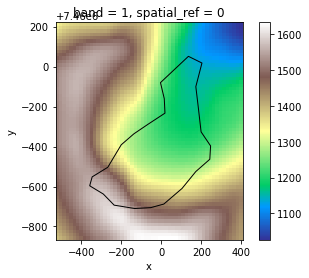

In [12]:
da = rioxarray.open_rasterio(dem_path)
f, ax = plt.subplots()
da.plot(cmap='terrain', ax=ax);
# Add the outlines
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

In [13]:
@entity_task(log)
def get_topo_predictors(gdir):
    """Mandatory docstring
    """
        
    training_data = {'zmed': 0.0,
                 'zmax': 0.0,
                 'zmin': 0.0,
                 'area': 0.0,
                 'slope': 0.0,
                 'lat': 0.0,
                 'icecap': 0.0,
                 'ID': ""
        }
    
    gl_shp = gdir.read_shapefile('outlines')
    
    training_data['zmed'] = float(gl_shp.Zmed.values[0])
    training_data['zmax'] = float(gl_shp.Zmax.values[0])
    training_data['zmin'] = float(gl_shp.Zmin.values[0])
    training_data['area'] = gdir.rgi_area_km2
    training_data['lat'] = gdir.cenlat
    training_data['icecap'] = int(gdir.is_icecap)
    training_data['slope'] = float(gl_shp.Slope.values[0])
    training_data['ID'] = gdir.rgi_id
        
    return training_data

We parallelize this using the function as an entity task in OGGM

In [14]:
# topo_dicts = workflow.execute_entity_task(get_topo_predictors, gdirs)

In [15]:
# topo_df = pd.DataFrame(topo_dicts)
# topo_df.index = topo_df.ID
# topo_df.index.name = 'RGI_ID'
# topo_df.drop(columns='ID')

In [16]:
# topo_df.to_csv('topo_df.csv')

To avoid computing all topographical predictors each time, just load the previously stored file.

In [7]:
topo_df = pd.read_csv('topo_df.csv')

## Get glacier climate data

Now we get the climate data from CRU for each glacier. 

In [18]:
# global_tasks.compile_climate_input(gdirs)

In [5]:
climate_ds = xr.open_dataset('climate_input.nc')

Let's add the median glacier altitude to compute a temperature lapse rate.

In [8]:
climate_ds['zmed'] = ('rgi_id', topo_df['zmed'])

The compiled climate dataset has time coordinates in decimal years, which is useless. Let's convert them to Datetime.

In [18]:
def decimal_to_datetime(ds):
    datetimes = []
    for dec_year in ds.time.data:
        year = int(dec_year)
        rem = dec_year - year

        base = datetime(year, 1, 1)
        calendar_time = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem + 100000.0)
        datetimes.append(calendar_time)
        
    climate_ds['time'] = datetimes
        
    return climate_ds

We trim the data for the desired period.

In [16]:
period=np.arange(2000.0, 2020.0)
climate_ds = climate_ds.sel(time=period, method='nearest') 

Let's convert decimal years to datetime.

In [19]:
climate_ds = decimal_to_datetime(climate_ds)

In [88]:
climate_ds

<xarray.Dataset>
Dimensions:         (time: 20, rgi_id: 3417, year: 20)
Coordinates:
  * time            (time) datetime64[ns] 2000-01-02T03:46:40 ... 2019-01-02T...
  * rgi_id          (rgi_id) object 'RGI60-08.00001' ... 'RGI60-08.03417'
    hydro_year      (time) int64 2000 2001 2002 2003 ... 2016 2017 2018 2019
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
    calendar_year   (time) int64 1999 2000 2001 2002 ... 2015 2016 2017 2018
    calendar_month  (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
  * year            (year) int64 2000 2001 2002 2003 ... 2016 2017 2018 2019
Data variables:
    temp            (time, rgi_id) float64 -1.319 1.321 1.333 ... 23.02 13.14
    prcp            (time, rgi_id) float32 89.95 94.56 92.4 ... 232.1 217.6
    ref_hgt         (rgi_id) float64 353.0 273.0 692.0 ... 1.046e+03 827.0 771.0
    ref_pix_lon     (rgi_id) float64 33.75 33.58 33.75 ... 15.25 14.25 14.25
    ref_pix_lat     (rgi_id) float64 67.92 67.92 67.75 ... 66.75 66.08 65.92
    zmed            (rgi_id) float64 242.0 239.0 726.0 ... 1.581e+03 1.186e+03
    snow            (year, rgi_id) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rain            (year, rgi_id) float32 89.95 94.56 92.4 ... 232.1 217.6
Attributes:
    description:    OGGM model output
    oggm_version:   1.5.3
    calendar:       365-day no leap
    creation_date:  2022-06-24 13:19:30

The final step is to convert the dataset into a DataFrame in order to have a format ready to train ML models.

First we export the Dataset as is, which gives as monthly data:

In [93]:
mon_climate_df = climate_ds.to_dataframe()

In [94]:
mon_climate_df.reset_index(level='year', drop=True, inplace=True)

In [96]:
mon_climate_df.set_index('hydro_year', append=True)

hydro_month  calendar_year  \
time                rgi_id         hydro_year                               
2000-01-02 03:46:40 RGI60-08.00001 2000                  1           1999   
                                   2000                  1           1999   
                                   2000                  1           1999   
                                   2000                  1           1999   
                                   2000                  1           1999   
...                                                    ...            ...   
2019-01-02 03:46:40 RGI60-08.03417 2019                  1           2018   
                                   2019                  1           2018   
                                   2019                  1           2018   
                                   2019                  1           2018   
                                   2019                  1           2018   

                                               calendar_month       temp  \
time                rgi_id         hydro_year                              
2000-01-02 03:46:40 RGI60-08.00001 2000                    10  -1.318889   
                                   2000                    10  -1.318889   
                                   2000                    10  -1.318889   
                                   2000                    10  -1.318889   
                                   2000                    10  -1.318889   
...                                                       ...        ...   
2019-01-02 03:46:40 RGI60-08.03417 2019                    10  13.144444   
                                   2019                    10  13.144444   
                                   2019                    10  13.144444   
                                   2019                    10  13.144444   
                                   2019                    10  13.144444   

                                                     prcp  ref_hgt  \
time                rgi_id         hydro_year                        
2000-01-02 03:46:40 RGI60-08.00001 2000         89.949440    353.0   
                                   2000         89.949440    353.0   
                                   2000         89.949440    353.0   
                                   2000         89.949440    353.0   
                                   2000         89.949440    353.0   
...                                                   ...      ...   
2019-01-02 03:46:40 RGI60-08.03417 2019        217.587555    771.0   
                                   2019        217.587555    771.0   
                                   2019        217.587555    771.0   
                                   2019        217.587555    771.0   
                                   2019        217.587555    771.0   

                                               ref_pix_lon  ref_pix_lat  \
time                rgi_id         hydro_year                             
2000-01-02 03:46:40 RGI60-08.00001 2000              33.75    67.916667   
                                   2000              33.75    67.916667   
                                   2000              33.75    67.916667   
                                   2000              33.75    67.916667   
                                   2000              33.75    67.916667   
...                                                    ...          ...   
2019-01-02 03:46:40 RGI60-08.03417 2019              14.25    65.916667   
                                   2019              14.25    65.916667   
                                   2019              14.25    65.916667   
                                   2019              14.25    65.916667   
                                   2019              14.25    65.916667   

                                                 zmed       snow        rain  
time                rgi_id         hydro_year                                 
2000-01-02 

In [126]:
mon_climate_df

hydro_year  hydro_month  calendar_year  \
time                rgi_id                                                   
2000-01-02 03:46:40 RGI60-08.00001        2000            1           1999   
                    RGI60-08.00001        2000            1           1999   
                    RGI60-08.00001        2000            1           1999   
                    RGI60-08.00001        2000            1           1999   
                    RGI60-08.00001        2000            1           1999   
...                                        ...          ...            ...   
2019-01-02 03:46:40 RGI60-08.03417        2019            1           2018   
                    RGI60-08.03417        2019            1           2018   
                    RGI60-08.03417        2019            1           2018   
                    RGI60-08.03417        2019            1           2018   
                    RGI60-08.03417        2019            1           2018   

                                    calendar_month       temp        prcp  \
time                rgi_id                                                  
2000-01-02 03:46:40 RGI60-08.00001              10  -1.318889   89.949440   
                    RGI60-08.00001              10  -1.318889   89.949440   
                    RGI60-08.00001              10  -1.318889   89.949440   
                    RGI60-08.00001              10  -1.318889   89.949440   
                    RGI60-08.00001              10  -1.318889   89.949440   
...                                            ...        ...         ...   
2019-01-02 03:46:40 RGI60-08.03417              10  13.144444  217.587555   
                    RGI60-08.03417              10  13.144444  217.587555   
                    RGI60-08.03417              10  13.144444  217.587555   
                    RGI60-08.03417              10  13.144444  217.587555   
                    RGI60-08.03417              10  13.144444  217.587555   

                                    ref_hgt  ref_pix_lon  ref_pix_lat    zmed  \
time                rgi_id                                                      
2000-01-02 03:46:40 RGI60-08.00001    353.0        33.75    67.916667   242.0   
                    RGI60-08.00001    353.0        33.75    67.916667   242.0   
                    RGI60-08.00001    353.0        33.75    67.916667   242.0   
                    RGI60-08.00001    353.0        33.75    67.916667   242.0   
                    RGI60-08.00001    353.0        33.75    67.916667   242.0   
...                                     ...          ...          ...     ...   
2019-01-02 03:46:40 RGI60-08.03417    771.0        14.25    65.916667  1186.0   
                    RGI60-08.03417    771.0        14.25    65.916667  1186.0   
                    RGI60-08.03417    771.0        14.25    65.916667  1186.0   
                    RGI60-08.03417    771.0        14.25    65.916667  1186.0   
                    RGI60-08.03417    771.0        14.25    65.916667  1186.0   

                                         snow        rain  
time                rgi_id                                 
2000-01-02 03:46:40 RGI60-08.00001   0.000000   89.949440  
                    RGI60-08.00001   0.000000   50.515018  
                    RGI60-08.00001  59.345169    0.000000  
                    RGI60-08.00001  48.070133    0.000000  
                    RGI60-08.00001  78.174042    0.000000  
...                                       ...         ...  
2019-01-02 03:46:40 RGI60-08.03417   0.000000  104.149033  
                    RGI60-08.03417   0.000000  217.098801  
                    RGI60-08.03417   0.000000   89.045914  
                    RGI60-08.03417   0.000000  176.113358  
                    RGI60-08.03417   0.000000  217.587555  

[1366800 rows x 12 columns]

Then, we resample everything with an annual timestep in order to have annual variables to be included in the ML training dataset.

In [115]:
def get_annual_dataset(climate_ds, period=np.arange(2000.0, 2020.0)):
    """Mandatory docstring
    """    
    # Temperature
    climate_ds.temp.data = climate_ds.temp.data + 6.0/1000.0*(climate_ds.zmed.data - climate_ds.ref_hgt.data) # Super rough temperature lapse rate  
    yr_temp_ds = climate_ds.temp.where(climate_ds.temp > 0.0).groupby('hydro_year').sum()
    yr_temp_ds = yr_temp_ds.rename('PDD')
    
    # Snowfall
    yr_snow_ds = climate_ds.prcp.where(climate_ds.temp <= 0.0).groupby('hydro_year').sum()
    yr_snow_ds = yr_snow_ds.rename('snow')
    # Rainfall
    yr_rain_ds = climate_ds.prcp.where(climate_ds.temp > 0.0).groupby('hydro_year').sum()
    yr_rain_ds = yr_rain_ds.rename('rain')
    
    return yr_temp_ds, yr_snow_ds, yr_rain_ds

In [116]:
yr_temp_ds, yr_snow_ds, yr_rain_ds = get_annual_dataset(climate_ds)

And we finally export the 3 annual datasets as Dataframes.yr_temp_ds

In [117]:
yr_temp_df = yr_temp_ds.to_dataframe()
yr_snow_df = yr_snow_ds.to_dataframe()
yr_rain_df = yr_rain_ds.to_dataframe()

## Creating the ML dataset

Now we need a function that fetches the raw data from these different Dataframes and produces the right list of predictors for the ML models.

The ML models will take predictors for a given hydrological year comprising:

Climate data:

- Annual cumulative snowfall
- Annual cumulative rainfall
- Annual cumulative PDDs
- Monthly average temperature
- Monthly snowfall

Topographical data (around 2003):

- Median glacier altitude
- Maximum glacier altitude
- Minimum glacier altitude
- Glacier area
- Glacier average slope

To be added in order to better constrain ice dynamics:

- Average ice thickness


We start by merging the climate Dataframes.

In [119]:
yr_temp_snow_df = pd.merge(yr_temp_df, yr_snow_df, on=["rgi_id", "hydro_year"])

In [120]:
yr_climate_df = pd.merge(yr_temp_snow_df, yr_rain_df, on=["rgi_id", "hydro_year"])

And then we merge the annual and monthly climate datasets.

In [121]:
climate_df = pd.merge(yr_climate_df, mon_climate_df, on=["rgi_id", "hydro_year"])

TODO: finish to format matrix for training. Two options possible:
- Add monthly data as columns to be used at predictors. This would imply that the ML models would predict full years based on annual and monthly data. This is tricky to achieve with the current tabular data. We need to find a way to project the monthly data as a new dataset in which monthly PDDs, snow and rain are columns. 
- Simply keeping the tables as they are and feeding them with a monthly timestep. In that case we would have to compute the loss after many more predictions than with the first options (since the timestep is monthly instead of annual). Since the observations (target data) has a timestep of 10 years, this might be too much for the ML models to converge, as there might be too much drift. 